In [1]:
# path for the masks is at /scratch/atnguyen/aste_90x150x60/run_template/input_maskTransport/

# IMPORTANT NOTE HERE THIS RUN ALL IS LOADING FOR ASTE 270 BUT WE LATER RESET THE GRID TO ASTE 90

# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
dirroot = "/scratch3/atnguyen/aste_90x150x60/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
runstr= "run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/"
layers_path = dirroot + runstr
extL = "LAYERS"
dirmask = dirroot + "run_template/input_maskTransport/"
dirdiags = layers_path + "diags/BUDG/"
dirstate = layers_path + "diags/STATE/"

In [3]:
# set the parameters for the aste 90 grid
nx = 90
ncut1 = 150
ncut2 = 60
ny = 2*ncut1 + nx + ncut2
nz = 50
nfx = np.array([nx,0,nx,ncut2,ncut1])
nfy = np.array([ncut1, 0, nx,nx,nx])

In [4]:
# remake hf1 here just to check

nx = 90
ncut1 = 150
ncut2 = 60
ny = 2*ncut1+nx+ncut2   # this is 450
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

mygrid = {
    'dirGrid': dirgrid,
    'nFaces': 5,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','RAC','Depth','maskInC','DXG','DYG'] #  ,'DXG','DYG','DXC','DYC'] # 'XG','YG'
fldstr3d = ['hFacC'] #,'hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC'] # ,'hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','DRF','RF'] # ,'RF','DRC',

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirgrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirgrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirgrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

# mygrid['mskC'][mygrid['mskC'] == 0] = np.nan
RAC = mygrid['RAC']
mskC = mygrid['maskInC']

In [5]:
hf1 = mygrid['hFacC'][0] # top layer in z
hf1.shape

(450, 90)

In [6]:
# try to use rdmds
fileprefix = "/scratch3/atnguyen/aste_90x150x60/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v2_mskBasin.bin"
ind = np.fromfile(filename, dtype=np.int32)  # auto-reads .meta for shape/dtype/order
print(ind.shape)

(40500,)


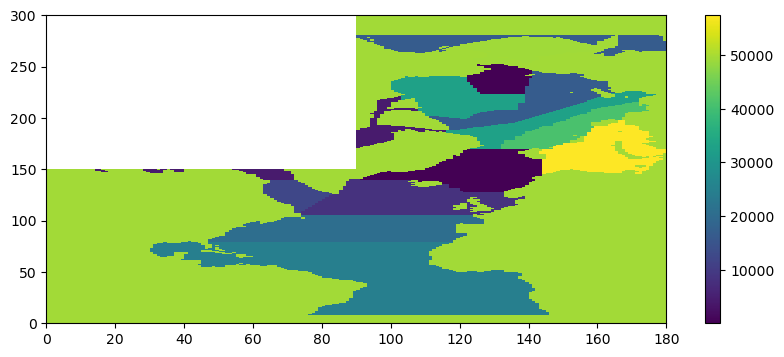

In [7]:
ind = ind.reshape(ny,nx)
plt.pcolormesh(get_aste_tracer(ind,nfx,nfy)[0])
# plt.xlim(140,180)
# plt.ylim(130,220)
plt.colorbar()

In [8]:
landmsk = np.zeros((ny,nx))
landmsk[hf1 == 0] = 1
landmsk[hf1 == 1] = np.nan

In [9]:
mymsk = np.full((ny,nx),np.nan)
mymsk[ind == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

In [10]:
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

In [11]:
# 2d
rac2d = read_float64(dirgrid + "RAC" + ".data")
print("RAC2d",rac2d.shape)

drf3d = read_float32(dirgrid + "DRF" + ".data")


rac2dtile = np.tile(rac2d,(nT-1,1)) #.shape

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat

hf2dtile = np.tile(hf2d,(nT-1,1))
ffac = 1e-6

RAC2d (40500,)
(100,)


In [12]:
# make sure we get the dt correct
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = np.array([2.,3.])


dt = ts2dte(fnames[1])-ts2dte(fnames[0])  # days
dt = dt.total_seconds()
dt

1200.0

In [13]:
tsstr = np.array(['0000000002','0000000003'])
t2 = int(tsstr[1])

In [14]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

# now 3d zfluxes
file_name = "budg3d_zflux_set1"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["ADVr_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)

hf = mygrid['hFacC']

ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_TH.reshape(nz, ny, nx), nfx, nfy))
ADV_hconv = ADV_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVh = ADV_hconv

trWtopADV = -(ADVr_TH)

ADVr = np.zeros((nz,ny,nx),dtype=float)
ADVr[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])  # this is not the way we did it in the original code but this is the way An has done it so we try

In [15]:
# try to use rdmds
fileprefix = "/scratch3/atnguyen/aste_90x150x60/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v2_mskBasin.bin"
ind = np.fromfile(filename, dtype=np.int32)  # auto-reads .meta for shape/dtype/order
orig_shape = (ind.shape)

ind2d = ind.reshape(ny,nx)

mymsk = np.full((ny,nx),np.nan)
mymsk[ind2d == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

In [16]:
mymsk2 = mymsk.copy()
mymsk2[:185,:] = np.nan
mymsk2[:,10:] = np.nan
mymsk2[140:155,54:55] = 1
mymsk2 *= hf1
mymsk2[mymsk2==0] = np.nan

mymsk_1d = mymsk2.reshape(orig_shape, order='C')

print(ind.shape, mymsk_1d.shape)  # both should be (40500,)

(40500,) (40500,)


In [17]:
# we can go ahead and define the xs and ys that we want to read from here
print(np.where(mymsk2 == 1))

#                           i indices              j indices
left_read = np.array([[54, 54, 54, 54, 54],[145, 146, 147, 148, 149]])          # where we read +ADVx_TH
right_read = np.array([[55, 55, 55, 55, 55],[145, 146, 147, 148, 149]])         # where we read -ADVx_TH
top_read = np.array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],[186, 186, 186, 186, 186, 186, 186, 186, 186, 186]])    # where we read -ADVy_TH
bot_read = np.array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],[185, 185, 185, 185, 185, 185, 185, 185, 185, 185]])    # where we read +ADVy_TH

(array([145, 146, 147, 148, 149, 185, 185, 185, 185, 185, 185, 185, 185,
       185, 185]), array([54, 54, 54, 54, 54,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]))


In [18]:
mymsk_1dtile = np.tile(mymsk_1d[np.newaxis,:],(nT-1,1))
hf2dtile.shape

(111, 40500)

In [19]:
ffac=1e-6
G_T=np.array([])
metaT=parsemeta(layers_path + "diags/LAYERS/layers_3d_Ttend." + "0000000003" + ".meta")
nFldsT = metaT["fldList"]
print(len(nFldsT))
setTtend=nFldsT.copy()
fldsIwant = np.array(['LaTh2TH','LaTz2TH'])


# check for the correct diagnostics
metaT['fldList']   # 13, 14, 15, 16, 19, 22
b = metaT['fldList']
ifldT = np.array([1,2])    # surf, hDiff, vDiff, hADV, vADV, total tend
# print(np.array(b)[ifldT])  # for G_T

# remake the following to look for the existing terms and see if we can recreate
# ['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']
ifldT = np.array([0,1,2,7,8,11])
print(np.array(b)[ifldT])  # for G_T

24
['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']


In [20]:
# load the G_T terms again with the mask in mind
# this will be a width 1 list

# make the G_T term
G_T = {}
G_T["all"] = {}
ts = tsstr[1]
    
# now loop through
G_T["all"][ts] = {}
for i in range(len(ifldT)-1, -1, -1):
    tmp = read_float64_skip(layers_path + "diags/LAYERS/layers_3d_Ttend." + tsstr[-1] + ".data", nx*ny*(nT-1),ifldT[i])
    tmp = np.reshape(tmp,(nT-1,nx*ny))

    # here we will want to multiply by the mask for the Barents Sea
    tmp = tmp * mymsk_1dtile * (rac2dtile * hf2dtile) #* ffac

    if i == ifldT.shape[0]-1:
        # if LTto2TH, do not remove from residual
        residT = tmp
    else:
        # else if vADV, hADV, vDiff, hDiff, surface, remove from residual
        residT = residT-tmp
    
    # just do the Barents Sea for this one
    a = np.nansum(tmp,axis=1)
    G_T["all"][ts][setTtend[ifldT[i]]] = a

G_T["all"][ts]["residT"] = np.nansum(residT,axis=1)

Text(0, 0.5, 'G_T ADVr m^3/s')

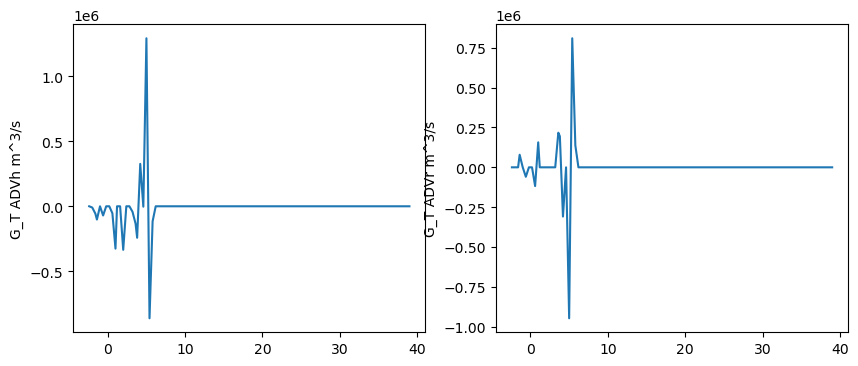

In [21]:
# plot this as a line graph with the T bins
GADVh = G_T["all"][ts]['LTha2TH']
GADVr = G_T["all"][ts]['LTza2TH']

fig = plt.figure()

ax = plt.subplot(121)
ax.plot(boundsT.flatten()[1:-1],GADVh)
ax.set_ylabel("G_T ADVh m^3/s")


ax = plt.subplot(122)
ax.plot(boundsT.flatten()[1:-1],GADVr)
ax.set_ylabel("G_T ADVr m^3/s")

In [22]:
# we need to also create the theta and salt bins for this area

# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(dirstate + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx) * hf
SALT = SALT.reshape(nz,ny,nx)

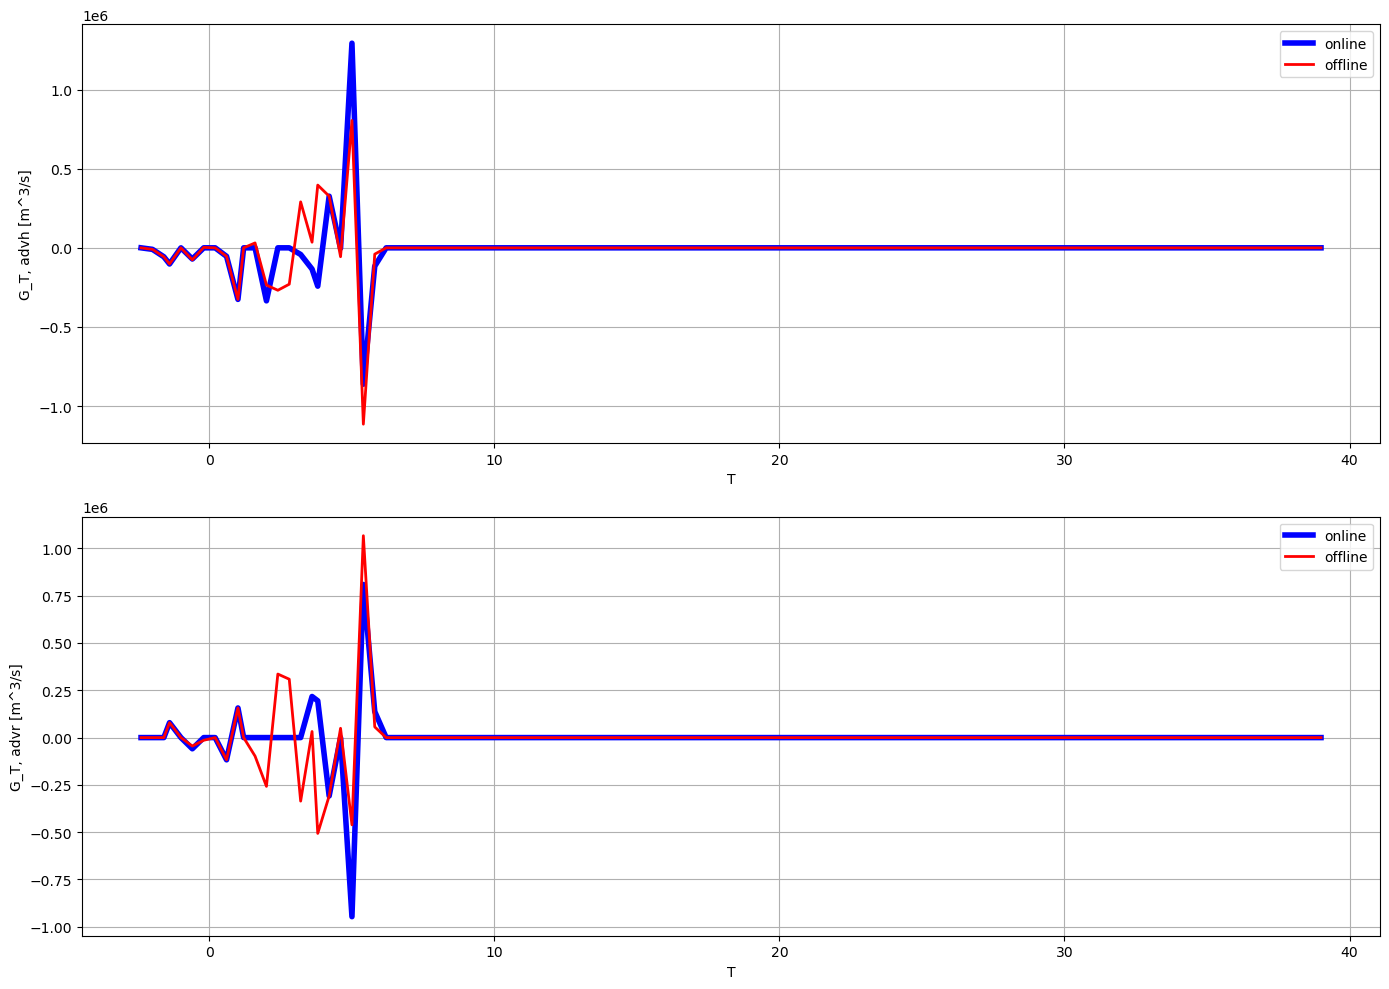

In [23]:
def _bincount_sum_with_nan(idx, values, n_bins):
    """MATLAB-like sum: if any NaN in a bin, that bin's sum is NaN."""
    idx = np.asarray(idx)
    values = np.asarray(values)
    ok = np.isfinite(values)
    s = np.bincount(idx[ok], weights=values[ok], minlength=n_bins).astype(float)
    any_nan = np.bincount(idx[~ok], minlength=n_bins) > 0
    s[any_nan] = np.nan
    return s

def plot_figure4_new(THETA, DFh, DFr, boundsT, binmidT, binwidthT1,
                     h_diff_layers, r_diff_layers, iiT=None):
    """
    Recreates Figure 4 (both panels) from replicate_layers_offline:
      Top:  G_T diffh — online vs offline(new)
      Bottom: G_T diffr — online vs offline(new)
    """
    # --- inputs & shapes ---
    THETA      = np.asarray(THETA)
    DFh        = np.asarray(DFh)
    DFr        = np.asarray(DFr)
    boundsT    = np.asarray(boundsT)
    binmidT    = np.asarray(binmidT)
    binwidthT1 = np.asarray(binwidthT1)      # length nT-1
    G_online_h = np.asarray(h_diff_layers)   # length nT-1
    G_online_r = np.asarray(r_diff_layers)   # length nT-1

    nT   = boundsT.size - 1
    nTm1 = nT - 1

    # x-locations for edge-based curves (length nTm1)
    x = boundsT[1:-1]

    # --- "new" interpretation: bin by binmidT intervals ---
    theta_flat = THETA.ravel()
    dfh_flat   = DFh.ravel()
    dfr_flat   = DFr.ravel()

    # binmidT[i] <= THETA < binmidT[i+1], i=0..nT-2
    bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
    valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)
    idx_mid     = bin_idx_mid[valid_mid]

    # per-bin sums with NaN-propagation
    DFh_new = _bincount_sum_with_nan(idx_mid, dfh_flat[valid_mid], nTm1)
    DFr_new = _bincount_sum_with_nan(idx_mid, dfr_flat[valid_mid], nTm1)

    # edge-based G (m^3/s): divide by edge binwidths
    G_off_new_h = DFh_new / binwidthT1
    G_off_new_r = DFr_new / binwidthT1

    # selection
    if iiT is None:
        iiT = slice(None)

    # --- plot: 2 rows, 1 column ---
    plt.figure(figsize=(14, 10))
    # Top: diffh
    plt.subplot(2, 1, 1)
    plt.plot(x[iiT], G_online_h[iiT], 'b-', linewidth=4, label='online')
    plt.plot(x[iiT], G_off_new_h[iiT], 'r-', linewidth=2, label='offline')
    plt.grid(True); plt.xlabel('T'); plt.ylabel('G_T, advh [m^3/s]')
    plt.legend(); plt.axis('tight')

    # Bottom: diffr
    plt.subplot(2, 1, 2)
    plt.plot(x[iiT], G_online_r[iiT], 'b-', linewidth=4, label='online')
    plt.plot(x[iiT], G_off_new_r[iiT], 'r-', linewidth=2, label='offline')
    plt.grid(True); plt.xlabel('T'); plt.ylabel('G_T, advr [m^3/s]')
    plt.legend(); plt.axis('tight')

    plt.tight_layout()

# Example:
a = ADVh*(np.tile(mymsk2[np.newaxis,:,:],(nz,1,1)))
a[np.isnan(a)] = 0
b = ADVr*(np.tile(mymsk2[np.newaxis,:,:],(nz,1,1)))
b[np.isnan(b)] = 0
plot_figure4_new(THETA, a, b, boundsT.flatten(), binmidT.flatten(), binwidthT1,
                               GADVh, GADVr, iiT=None)
plt.show()


In [24]:
# we can go ahead and define the xs and ys that we want to read from here
print(np.where(mymsk2 == 1))

#                           i indices              j indices
left_read = np.array([[54, 54, 54, 54, 54],[145, 146, 147, 148, 149]])          # where we read +ADVx_TH
right_read = np.array([[55, 55, 55, 55, 55],[145, 146, 147, 148, 149]])         # where we read -ADVx_TH
top_read = np.array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],[186, 186, 186, 186, 186, 186, 186, 186, 186, 186]])    # where we read -ADVy_TH
bot_read = np.array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],[185, 185, 185, 185, 185, 185, 185, 185, 185, 185]])    # where we read +ADVy_TH

(array([145, 146, 147, 148, 149, 185, 185, 185, 185, 185, 185, 185, 185,
       185, 185]), array([54, 54, 54, 54, 54,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]))


In [27]:
# do for the BSO based on the y,x,and choose_UV
ADV_gates = {}

ADVx_TH = ADVx_TH.reshape((nz,ny,nx))
ADVy_TH = ADVy_TH.reshape((nz,ny,nx))


ADV_west = np.zeros((nz,ny,nx))
for j,i, in zip(left_read[1],left_read[0]):
    ADV_west[:,j,i] += ADVx_TH[:,j,i]
for j,i, in zip(top_read[1],top_read[0]):
    ADV_west[:,j-1,i] -= ADVy_TH[:,j,i]
ADV_gates["west"] = ADV_west

ADV_east = np.zeros((nz,ny,nx))
for j,i, in zip(right_read[1],right_read[0]):
    ADV_east[:,j,i-1] -= ADVx_TH[:,j,i]
for j,i, in zip(bot_read[1],bot_read[0]):
    ADV_east[:,j,i] += ADVy_TH[:,j,i]
ADV_gates["east"] = ADV_east

In [28]:

def bin_dF_by_theta(THETA, boundsT, DFh, DFr):
    """
    Replicates the MATLAB loop:
      for i=1:nT
        ij = find(T >= boundsT(i) & T < boundsT(i+1));
        Lij(i)        = length(ij);
        dF_Tcenter(2,i) = sum(DFh(ij));   % degC m^3/s
        dF_Tcenter(3,i) = sum(DFr(ij));   % degC m^3/s
      end
    but using THETA (3D) instead of T, and handling NaNs like MATLAB:
    if any DFh/DFr in a bin are NaN, the sum for that bin is NaN.

    Parameters
    ----------
    THETA  : ndarray (3D or any shape) — binning variable, may contain NaNs
    boundsT: (N+1,)  array of bin edges
    DFh    : ndarray same shape as THETA (degC m^3/s), may contain NaNs
    DFr    : ndarray same shape as THETA (degC m^3/s), may contain NaNs

    Returns
    -------
    Lij      : (N,) int    counts per bin (based on THETA only)
    dFh_bin  : (N,) float  sum of DFh in each bin (NaN if any DFh in bin is NaN)
    DFr_bin  : (N,) float  sum of DFr in each bin (NaN if any DFr in bin is NaN)
    """
    THETA   = np.asarray(THETA)
    boundsT = np.asarray(boundsT)
    DFh     = np.asarray(DFh)
    DFr     = np.asarray(DFr)

    nT = boundsT.size - 1

    # Flatten for vectorized binning
    theta = THETA.ravel()
    dfh   = DFh.ravel()
    dfr   = DFr.ravel()

    # Bin indices for [lower, upper) using np.digitize(..., right=False)
    bin_idx = np.digitize(theta, boundsT, right=False) - 1

    # Valid THETA: finite and within bin range
    valid_theta = np.isfinite(theta) & (bin_idx >= 0) & (bin_idx < nT)
    idx = bin_idx[valid_theta]

    # Lij = count of THETA in each bin (regardless of DFh/DFr NaNs)
    Lij = np.bincount(idx, minlength=nT)

    # ----- DFh sums with MATLAB-like NaN propagation -----
    vals_h = dfh[valid_theta]
    nan_h  = np.isnan(vals_h)

    # Sum the non-NaN values
    sum_h = np.bincount(idx[~nan_h], weights=vals_h[~nan_h], minlength=nT).astype(float)

    # If any NaN occurred in a bin, set that bin's sum to NaN
    any_nan_h = np.bincount(idx[nan_h], minlength=nT) > 0
    sum_h[any_nan_h] = np.nan
    dFh_bin = sum_h

    # ----- DFr sums with MATLAB-like NaN propagation -----
    vals_r = dfr[valid_theta]
    nan_r  = np.isnan(vals_r)

    sum_r = np.bincount(idx[~nan_r], weights=vals_r[~nan_r], minlength=nT).astype(float)
    any_nan_r = np.bincount(idx[nan_r], minlength=nT) > 0
    sum_r[any_nan_r] = np.nan
    DFr_bin = sum_r

    return Lij, dFh_bin, DFr_bin

In [143]:
Lij, adv_hconv_binned, adv_rconv_binned = bin_dF_by_theta(THETA, boundsT[:,0,0], ADV_gates["west"], ADV_gates["east"])

# --- Move to edges by averaging adjacent centers ---
ADV_TedgeW = 0.5 * (adv_hconv_binned[:-1] - adv_hconv_binned[1:])   # move to the edge beceause this is already an integral
ADV_TedgeE = 0.5 * (adv_rconv_binned[:-1] - adv_rconv_binned[1:])   # move to the edge beceause this is already an integral


G_T_offlineW = ADV_TedgeW / binwidthT1
G_T_offlineE = ADV_TedgeE / binwidthT1
print(G_T_offlineW.shape)

(111,)


In [133]:

def _bincount_sum_with_nan(idx, vals, n):
    vals = np.asarray(vals)
    nan  = ~np.isfinite(vals)
    sums = np.bincount(idx[~nan], weights=vals[~nan], minlength=n).astype(float)
    anyn = np.bincount(idx[nan], minlength=n) > 0
    sums[anyn] = np.nan
    return sums

def bin_heat_to_edges(THETA, binmidT, HEAT_3D):
    theta = np.asarray(THETA).ravel()
    heat  = np.asarray(HEAT_3D).ravel()
    binmidT = np.asarray(binmidT)
    nTm1 = binmidT.size - 1
    # binmidT[i] <= THETA < binmidT[i+1]
    idx = np.digitize(theta, binmidT, right=False) - 1
    valid = (idx >= 0) & (idx < nTm1) & np.isfinite(theta)
    H_edge = _bincount_sum_with_nan(idx[valid], heat[valid], nTm1)  # °C m^3/s per edge
    # representative T* per edge bin (use midpoints; you can swap in a mean if you prefer)
    Tstar = 0.5*(binmidT[:-1] + binmidT[1:])
    return H_edge, Tstar

H_W_edge, Tstar = bin_heat_to_edges(THETA, binmidT.flatten(), ADV_gates["west"])
H_E_edge, _     = bin_heat_to_edges(THETA, binmidT.flatten(), ADV_gates["east"])

# Convert to volume and then to G_T on edges
eps = 1e-12
Q_W = np.divide(H_W_edge, Tstar, out=np.full_like(H_W_edge, np.nan), where=np.abs(Tstar)>eps)
Q_E = np.divide(H_E_edge, Tstar, out=np.full_like(H_E_edge, np.nan), where=np.abs(Tstar)>eps)

G_T_offlineW = Q_W / binwidthT1     # m^3 s^-1 per °C
G_T_offlineE = Q_E / binwidthT1

G_edges = G_T_offlineW + G_T_offlineE   # length nT-1

Text(0.5, 1.0, 'Without interp to edges after binning')

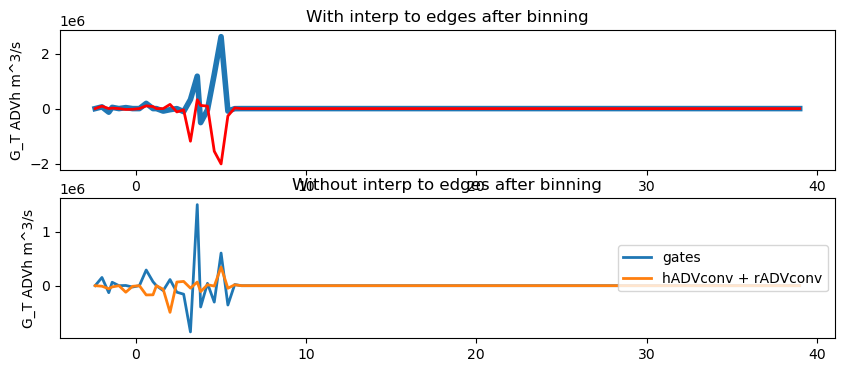

In [134]:
fig = plt.figure()

ax = plt.subplot(211)
ax.plot(boundsT.flatten()[1:-1],G_T_offlineW,linewidth=4, label='online')
ax.plot(boundsT.flatten()[1:-1], G_T_offlineE, 'r-', linewidth=2, label='offline')
ax.set_ylabel("G_T ADVh m^3/s")
ax.set_title("With interp to edges after binning")

ax = plt.subplot(212)
ax.plot(boundsT.flatten()[1:-1],G_edges,linewidth=2, label='gates')
ax.plot(boundsT.flatten()[1:-1],tester,linewidth=2, label='hADVconv + rADVconv')
ax.legend(loc="right")
ax.set_ylabel("G_T ADVh m^3/s")
ax.set_title("Without interp to edges after binning")


In [92]:
# make sure we're actually plotting the ADV convergence terms here
a = ADVh*(np.tile(mymsk2[np.newaxis,:,:],(nz,1,1)))
a[np.isnan(a)] = 0
b = ADVr*(np.tile(mymsk2[np.newaxis,:,:],(nz,1,1)))
b[np.isnan(b)] = 0

# --- inputs & shapes ---
THETA      = np.asarray(THETA)
DFh        = np.asarray(a)
DFr        = np.asarray(b)
boundsT    = np.asarray(boundsT)
binmidT    = np.asarray(binmidT)
binwidthT1 = np.asarray(binwidthT1)      # length nT-1

nT   = boundsT.size - 1
nTm1 = nT - 1

# x-locations for edge-based curves (length nTm1)
x = boundsT[1:-1]

# --- "new" interpretation: bin by binmidT intervals ---
theta_flat = THETA.ravel()
dfh_flat   = DFh.ravel()
dfr_flat   = DFr.ravel()

# binmidT[i] <= THETA < binmidT[i+1], i=0..nT-2
bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)
idx_mid     = bin_idx_mid[valid_mid]

# per-bin sums with NaN-propagation
DFh_new = _bincount_sum_with_nan(idx_mid, dfh_flat[valid_mid], nTm1)
DFr_new = _bincount_sum_with_nan(idx_mid, dfr_flat[valid_mid], nTm1)

# edge-based G (m^3/s): divide by edge binwidths
G_off_new_h = DFh_new / binwidthT1
G_off_new_r = DFr_new / binwidthT1

In [93]:
tester = G_off_new_h + G_off_new_r

In [124]:
print(np.nansum(tester))
print(np.nansum(G_T_offlineW + G_T_offlineE))


def nan_moving_avg(y, win=3):
    y = np.asarray(y, float)
    w = np.ones(win, float)
    # valid mask
    m = np.isfinite(y).astype(float)
    y0 = np.nan_to_num(y, nan=0.0)
    num = np.convolve(y0, w, mode='same')
    den = np.convolve(m,  w, mode='same')
    out = np.divide(num, den, out=np.full_like(num, np.nan), where=den>0)
    return out

G = G_T_offlineW + G_T_offlineE         # shape (nT-1,)
G_smooth = nan_moving_avg(G, win=7)
G_smooth.shape

-740598.73388016
428584.9666636145


(111,)

In [125]:
def G_T_from_gate_samples(THETA, binmidT, binwidthT1, ADV_TH_gate, tol=1e-8):
    """
    Gate-based G_T on T-edges (length nT-1).
    THETA:        (nz,ny,nx) center temperature used to bin
    ADV_TH_gate:  (nz,ny,nx) gate heat transport [°C m^3/s], + into domain
    binmidT:      (nT-1,) edge coordinates (same grid you use for ADVh/ADVr)
    binwidthT1:   (nT-1,) edge widths
    """
    theta = np.asarray(THETA, float).ravel()
    heat  = np.asarray(ADV_TH_gate, float).ravel()
    edges = np.asarray(binmidT, float)
    dT    = np.asarray(binwidthT1, float)
    nTm1  = edges.size - 1

    # Per-sample volume at the gate: q = heat / theta
    finite = np.isfinite(theta) & np.isfinite(heat) & (np.abs(theta) > tol)
    q = np.empty_like(heat); q[:] = np.nan
    q[finite] = heat[finite] / theta[finite]   # m^3/s

    # Bin by T-edges: edges[i] <= THETA < edges[i+1]
    idx = np.digitize(theta[finite], edges, right=False) - 1
    valid = (idx >= 0) & (idx < nTm1)

    # Sum q per edge bin (NaN-safe: bins with any NaNs beyond 'finite' step are already excluded)
    Q_edge = np.zeros(nTm1, float)
    np.add.at(Q_edge, idx[valid], q[finite][valid])  # m^3/s per T-edge bin

    # Transform per degree
    G_T_gate = np.divide(Q_edge, dT, out=np.full_like(Q_edge, np.nan), where=dT > 0)
    return G_T_gate
    
G_T_west = G_T_from_gate_samples(THETA, binmidT.flatten(), binwidthT1.flatten(), ADV_gates["west"])
G_T_east = G_T_from_gate_samples(THETA, binmidT.flatten(), binwidthT1.flatten(), ADV_gates["east"])

In [126]:
G_T_west.shape

(111,)

Text(0.5, 1.0, 'Without interp to edges after binning')

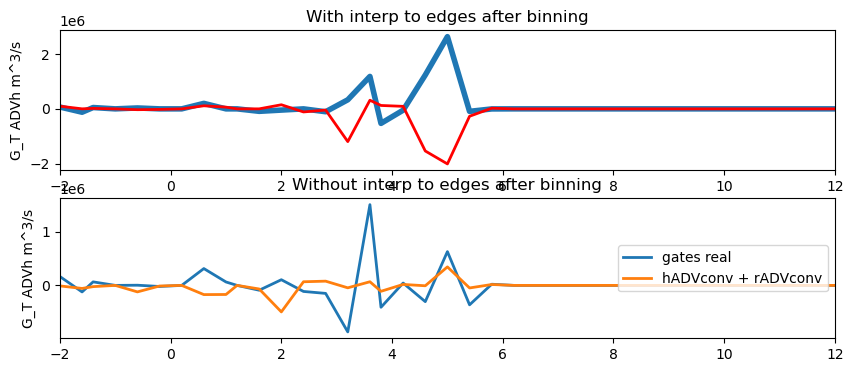

In [128]:
fig = plt.figure()

ax = plt.subplot(211)
ax.plot(boundsT.flatten()[1:-1],G_T_west,linewidth=4, label='online')
ax.plot(boundsT.flatten()[1:-1], G_T_east, 'r-', linewidth=2, label='offline')
ax.set_ylabel("G_T ADVh m^3/s")
ax.set_title("With interp to edges after binning")
ax.set_xlim(-2,12)

ax = plt.subplot(212)
ax.plot(boundsT.flatten()[1:-1],(G_T_west + G_T_east),linewidth=2, label='gates real')
# ax.plot(boundsT.flatten()[1:-1],(G_smooth),linewidth=2, label='gates smooth')

# ax.plot(boundsT.flatten()[1:-1],G_off_new_h,linewidth=2, label='hADVconv')
# ax.plot(boundsT.flatten()[1:-1],G_off_new_r,linewidth=2, label='rADVconv')

ax.plot(boundsT.flatten()[1:-1],tester,linewidth=2, label='hADVconv + rADVconv')
ax.set_xlim(-2,12)
ax.legend(loc="right")
ax.set_ylabel("G_T ADVh m^3/s")
ax.set_title("Without interp to edges after binning")


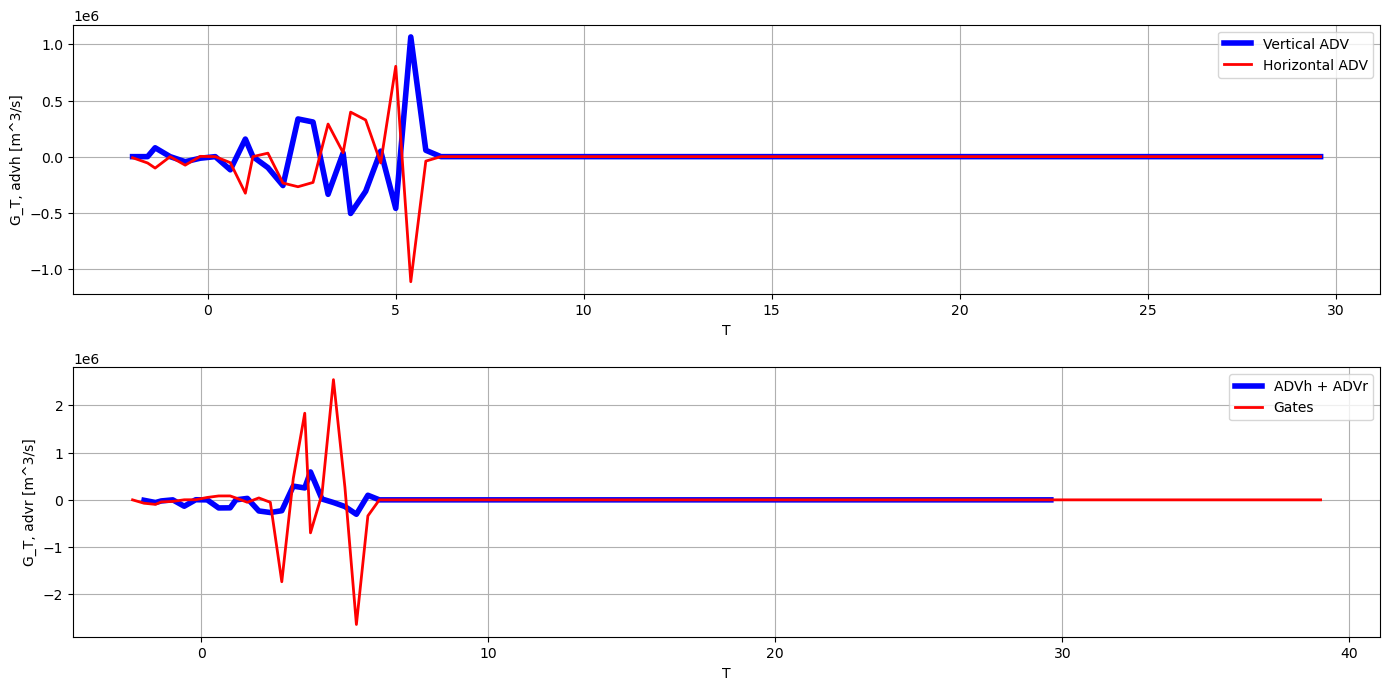

In [51]:
def compare_to_gates(THETA, DFh, DFr, boundsT, binmidT, binwidthT1,
                     h_diff_layers, r_diff_layers, G_T_offlineW, G_T_offlineE, iiT=None):
    """
    Recreates Figure 4 (both panels) from replicate_layers_offline:
      Top:  G_T diffh — online vs offline(new)
      Bottom: G_T diffr — online vs offline(new)
    """
    # --- inputs & shapes ---
    THETA      = np.asarray(THETA)
    DFh        = np.asarray(DFh)
    DFr        = np.asarray(DFr)
    boundsT    = np.asarray(boundsT)
    binmidT    = np.asarray(binmidT)
    binwidthT1 = np.asarray(binwidthT1)      # length nT-1
    G_online_h = np.asarray(h_diff_layers)   # length nT-1
    G_online_r = np.asarray(r_diff_layers)   # length nT-1

    nT   = boundsT.size - 1
    nTm1 = nT - 1

    # x-locations for edge-based curves (length nTm1)
    x = boundsT[1:-1]

    # --- "new" interpretation: bin by binmidT intervals ---
    theta_flat = THETA.ravel()
    dfh_flat   = DFh.ravel()
    dfr_flat   = DFr.ravel()

    # binmidT[i] <= THETA < binmidT[i+1], i=0..nT-2
    bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
    valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)
    idx_mid     = bin_idx_mid[valid_mid]

    # per-bin sums with NaN-propagation
    DFh_new = _bincount_sum_with_nan(idx_mid, dfh_flat[valid_mid], nTm1)
    DFr_new = _bincount_sum_with_nan(idx_mid, dfr_flat[valid_mid], nTm1)

    # edge-based G (m^3/s): divide by edge binwidths
    G_off_new_h = DFh_new / binwidthT1
    G_off_new_r = DFr_new / binwidthT1

    # selection
    if iiT is None:
        iiT = slice(None)

    test = G_T_offlineW + G_T_offlineE
    
    # --- plot: 2 rows, 1 column ---
    plt.figure(figsize=(14, 10))
    # Top: diffh
    plt.subplot(3, 1, 1)
    plt.plot(x[iiT], G_off_new_r[iiT], 'b-', linewidth=4, label='Vertical ADV')
    plt.plot(x[iiT], G_off_new_h[iiT], 'r-', linewidth=2, label='Horizontal ADV')
    plt.grid(True); plt.xlabel('T'); plt.ylabel('G_T, advh [m^3/s]')
    plt.legend(); plt.axis('tight')

    # Bottom: diffr
    plt.subplot(3, 1, 2)
    plt.plot(x[iiT], G_online_r[iiT] + G_off_new_h[iiT], 'b-', linewidth=4, label='ADVh + ADVr')
    plt.plot(x[iiT], test, 'r-', linewidth=2, label='Gates')
    plt.grid(True); plt.xlabel('T'); plt.ylabel('G_T, advr [m^3/s]')
    plt.legend(); plt.axis('tight')

    plt.tight_layout()

# Example:
a = ADVh*(np.tile(mymsk2[np.newaxis,:,:],(nz,1,1)))
a[np.isnan(a)] = 0
b = ADVr*(np.tile(mymsk2[np.newaxis,:,:],(nz,1,1)))
b[np.isnan(b)] = 0
compare_to_gates(THETA, a, b, boundsT.flatten(), binmidT.flatten(), binwidthT1,
                               GADVh, GADVr, G_T_offlineW, G_T_offlineE, iiT=None)
plt.show()


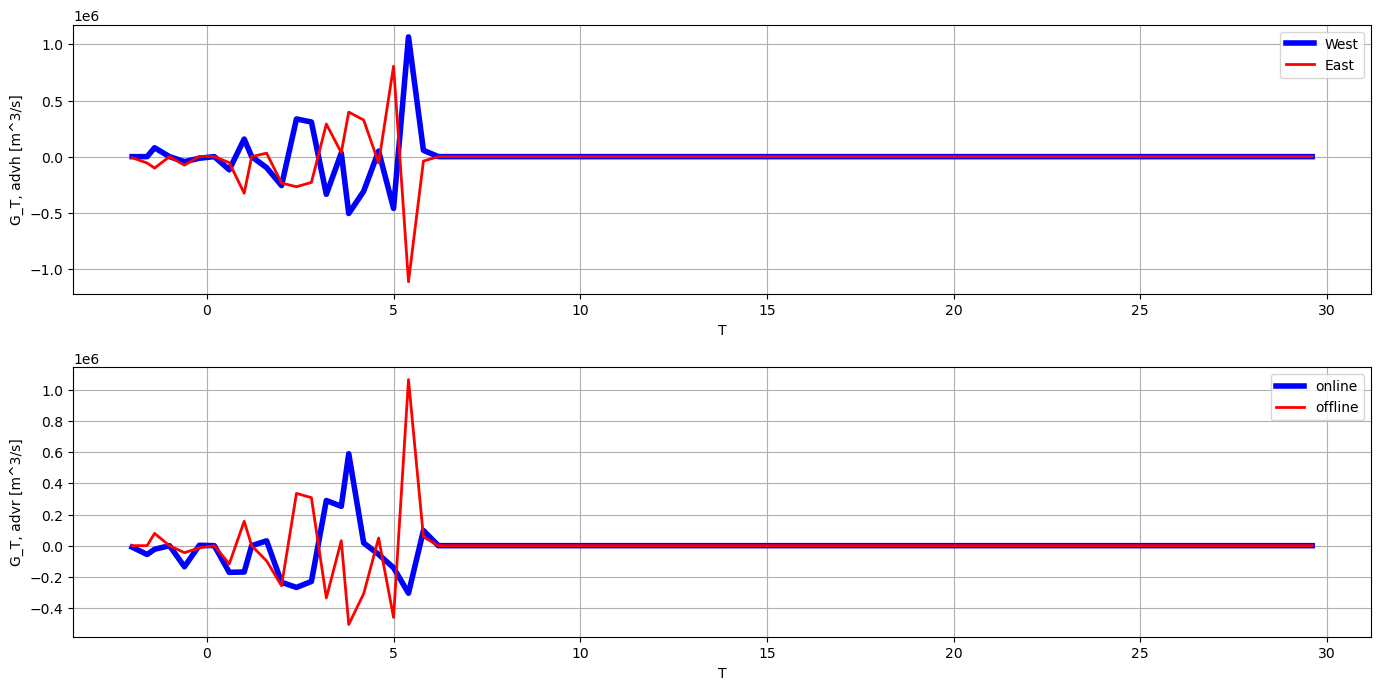

In [46]:
compare_to_gates(THETA, a, b, boundsT.flatten(), binmidT.flatten(), binwidthT1,
                               GADVh, GADVr, iiT=None)
plt.show()

## I don't think the following is correct because we should not be doing anything with face temperature.

In [141]:
# create the volume and bin this
DXG3d = np.tile(mygrid['DXG'][np.newaxis,:,:],(nz,1,1))
DYG3d = np.tile(mygrid['DYG'][np.newaxis,:,:],(nz,1,1))
DRF3d = np.tile(mygrid['DRF'][:,np.newaxis,np.newaxis],(1,ny,nx))

# grab the UVEL and VVEL for this timestep
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
VVELMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])  # m/s
UVELMASS = UVELMASS.reshape(nz,ny,nx)
VVELMASS = VVELMASS.reshape(nz,ny,nx)


# create the same gateways as we do below with UVELMASS and VVELMASS
VEL_gates = {}

VEL_west = np.zeros((nz,ny,nx))
for j,i, in zip(left_read[1],left_read[0]):
    VEL_west[:,j,i] += UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
for j,i, in zip(top_read[1],top_read[0]):
    VEL_west[:,j-1,i] -= VVELMASS[:,j,i] * DXG3d[:,j,i] * DRF3d[:,j,i]
VEL_gates["west"] = VEL_west

VEL_east = np.zeros((nz,ny,nx))
for j,i, in zip(right_read[1],right_read[0]):
    VEL_east[:,j,i-1] -= UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
for j,i, in zip(bot_read[1],bot_read[0]):
    VEL_east[:,j,i] += VVELMASS[:,j,i] * DXG3d[:,j,i] * DRF3d[:,j,i]
VEL_gates["east"] = VEL_east



# --- inputs & shapes ---
THETA      = np.asarray(THETA)
ADVw        = np.asarray(VEL_gates["west"])
ADVe        = np.asarray(VEL_gates["east"])
boundsT    = np.asarray(boundsT)
binmidT    = np.asarray(binmidT)
binwidthT1 = np.asarray(binwidthT1)      # length nT-1

nT   = boundsT.size - 1
nTm1 = nT - 1

# x-locations for edge-based curves (length nTm1)
x = boundsT[1:-1]

# --- "new" interpretation: bin by binmidT intervals ---
theta_flat = THETA.ravel()
ADVw_flat   = ADVw.ravel()
ADVe_flat   = ADVe.ravel()

# binmidT[i] <= THETA < binmidT[i+1], i=0..nT-2
bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)
idx_mid     = bin_idx_mid[valid_mid]

# per-bin sums with NaN-propagation
ADVw_flat_new = _bincount_sum_with_nan(idx_mid, ADVw_flat[valid_mid], nTm1)
ADVe_flat_new = _bincount_sum_with_nan(idx_mid, ADVe_flat[valid_mid], nTm1)

# not sure if I need to move these to the edges or if that would make a difference (An did it this way before)

# edge-based G (m^3/s): divide by edge binwidths
G_off_new_h = ADVw_flat_new #/ binwidthT1
G_off_new_r = ADVe_flat_new #/ binwidthT1

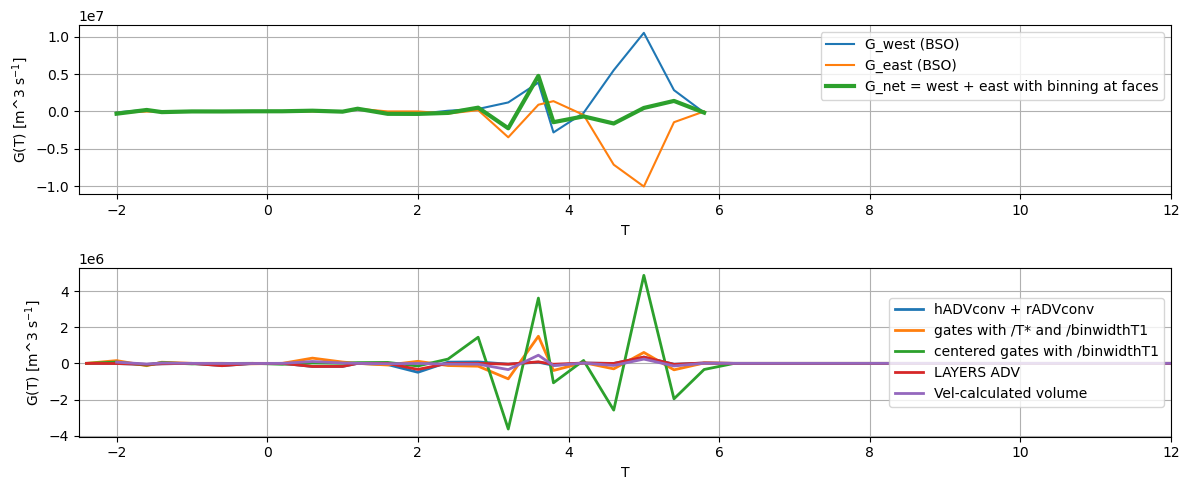

In [145]:

# ---------- helpers ----------
def _bincount_sum_with_nan(idx, vals, nout):
    finite = np.isfinite(vals)
    sums   = np.bincount(idx[finite], vals[finite], minlength=nout).astype(float)
    cnts   = np.bincount(idx[finite], None,       minlength=nout).astype(float)
    sums[cnts == 0] = np.nan
    return sums

def donor_theta_xfaces(THETA, ADVx_TH):
    """
    THETA   : (nz, ny, nx) cell-centered tracer
    ADVx_TH : (nz, ny, nx+1) theta flux across x-faces; + eastward
    returns : donor (upwind) THETA on x-faces, shape (nz, ny, nx+1)
    """
    # left neighbor for face i is cell i-1, clipped at 0
    theta_L = np.pad(THETA, ((0,0),(0,0),(1,0)), mode='edge')          # (nz, ny, nx+1)
    # right neighbor for face i is cell i, clipped at nx-1 for the last face
    theta_R = np.pad(THETA, ((0,0),(0,0),(0,1)), mode='edge')          # (nz, ny, nx+1)

    # upwind pick
    return np.where(ADVx_TH >= 0, theta_L[:,:,:-1], theta_R[:,:,:-1])

def donor_theta_yfaces(THETA, ADVy_TH):
    """
    THETA   : (nz, ny, nx) cell-centered tracer
    ADVy_TH : (nz, ny+1, nx) theta flux across y-faces; + northward
    returns : donor (upwind) THETA on y-faces, shape (nz, ny+1, nx)
    """
    # south neighbor for face j is cell j-1, clipped at 0
    theta_S = np.pad(THETA, ((0,0),(1,0),(0,0)), mode='edge')          # (nz, ny+1, nx)
    # north neighbor for face j is cell j, clipped at ny-1 for the last face
    theta_N = np.pad(THETA, ((0,0),(0,1),(0,0)), mode='edge')          # (nz, ny+1, nx)

    # upwind pick
    return np.where(ADVy_TH >= 0, theta_S[:,:-1,:], theta_N[:,:-1,:])

def bin_gate_GT_from_masks(
    THETA, ADVx_TH, ADVy_TH,
    binmidT, boundsT, binwidthT1,
    xface_mask, yface_mask,
    sign_x=+1.0, sign_y=+1.0
):
    """
    Bin gate transport into T-space using donor temperatures on faces selected by masks.
    sign_x/sign_y flip the orientation so positive means 'into' your gate by your convention.
    """
    boundsT    = np.asarray(boundsT)
    binmidT    = np.asarray(binmidT)
    binwidthT1 = np.asarray(binwidthT1)
    nT   = boundsT.size - 1
    nTm1 = nT - 1

    # donor temps at faces
    THx = donor_theta_xfaces(THETA, ADVx_TH)   # (nz,ny,nx+1)
    THy = donor_theta_yfaces(THETA, ADVy_TH)   # (nz,ny+1,nx)

    # pull the selected faces with the requested signs
    Fx = (sign_x * ADVx_TH)[xface_mask[:,:,:-1]]
    Fy = (sign_y * ADVy_TH)[yface_mask[:,:-1,:]]
    Tx = THx[xface_mask[:,:,:-1]]
    Ty = THy[yface_mask[:,:-1,:]]

    # concatenate all selected faces
    F = np.concatenate([Fx.ravel(), Fy.ravel()])  # units: degC * m^3/s
    T = np.concatenate([Tx.ravel(), Ty.ravel()])

    # bin by binmidT intervals: binmidT[i] <= T < binmidT[i+1]
    bin_idx = np.digitize(T, binmidT, right=False) - 1
    valid   = (bin_idx >= 0) & (bin_idx < nTm1) & np.isfinite(T) & np.isfinite(F)

    S = _bincount_sum_with_nan(bin_idx[valid], F[valid], nTm1)  # sum per T-edge bin
    G = S / binwidthT1                                          # convert to m^3/s per T-edge
    x = boundsT[1:-1]
    return x, G

# ---------- main: build masks from your gate picks & compute G ----------
def compute_gate_G(
    THETA,                 # (nz,ny,nx)
    ADVx_TH, ADVy_TH,      # (nz,ny,nx+1), (nz,ny+1,nx)
    boundsT, binmidT, binwidthT1,
    left_read, right_read, top_read, bot_read
):
    """
    Build face masks from your left/right/top/bottom picks and return:
        x, G_west, G_east, G_net
    Conventions matched to your snippet:
      - WEST gate:  +ADVx on 'left' faces,  -ADVy on 'top' faces
      - EAST gate:  -ADVx on 'right' faces, +ADVy on 'bottom' faces
    """
    nz, ny, nx = THETA.shape

    # masks on native face grids
    xmask_west  = np.zeros((nz, ny, nx+1), dtype=bool)   # x-faces (vertical segment)
    ymask_west  = np.zeros((nz, ny+1, nx), dtype=bool)   # y-faces (horizontal segment)
    xmask_east  = np.zeros((nz, ny, nx+1), dtype=bool)
    ymask_east  = np.zeros((nz, ny+1, nx), dtype=bool)

    # Populate masks from your (i,j) index lists.
    # Note: your loops used "for j,i in zip(<read>[1], <read>[0])", so we do the same mapping.
    # These indices should already be valid for the corresponding face grids.
    for j, i in zip(left_read[1], left_read[0]):   # x-faces on west segment
        xmask_west[:, j, i] = True
    for j, i in zip(top_read[1], top_read[0]):     # y-faces on top segment (west gate)
        ymask_west[:, j, i] = True

    for j, i in zip(right_read[1], right_read[0]): # x-faces on east segment
        xmask_east[:, j, i] = True
    for j, i in zip(bot_read[1], bot_read[0]):     # y-faces on bottom segment (east gate)
        ymask_east[:, j, i] = True

    # Compute G(T) for each side with signs matching your snippet
    # West: ADV_west += ADVx(left), ADV_west -= ADVy(top)
    x_west, G_west = bin_gate_GT_from_masks(
        THETA, ADVx_TH, ADVy_TH, binmidT, boundsT, binwidthT1,
        xmask_west, ymask_west, sign_x=+1.0, sign_y=-1.0
    )

    # East: ADV_east -= ADVx(right), ADV_east += ADVy(bottom)
    x_east, G_east = bin_gate_GT_from_masks(
        THETA, ADVx_TH, ADVy_TH, binmidT, boundsT, binwidthT1,
        xmask_east, ymask_east, sign_x=-1.0, sign_y=+1.0
    )

    # Basic sanity: x_west and x_east should be identical
    if not np.allclose(x_west, x_east, equal_nan=True):
        raise ValueError("boundsT mismatch between west and east computations.")
    x = x_west

    G_net = np.where(np.isnan(G_west) & np.isnan(G_east), np.nan,
                     np.nan_to_num(G_west) + np.nan_to_num(G_east))

    return x, G_west, G_east, G_net

# THETA: (nz,ny,nx)
# ADVx_TH: (nz,ny,nx+1)   # theta-adv flux on x-faces
# ADVy_TH: (nz,ny+1,nx)   # theta-adv flux on y-faces
# boundsT, binmidT, binwidthT1 as in your workflow
# left_read, right_read, top_read, bot_read: index arrays (i-list, j-list)

x, G_west, G_east, G_net = compute_gate_G(
    THETA, ADVx_TH.reshape(nz,ny,nx), ADVy_TH.reshape(nz,ny,nx),
    boundsT.flatten(), binmidT.flatten(), binwidthT1.flatten(),
    left_read, right_read, top_read, bot_read
)

# Optional quick plot:
plt.figure(figsize=(12,5))

ax = plt.subplot(211)
ax.plot(x, G_west, label='G_west (BSO)')
ax.plot(x, G_east, label='G_east (BSO)')
ax.plot(x, G_net,  lw=3, label='G_net = west + east with binning at faces')
ax.set_xlim(-2.5,12)

plt.grid(True); plt.xlabel('T'); plt.ylabel('G(T) [m^3 s$^{-1}$]')
plt.legend(); plt.tight_layout()

ax = plt.subplot(212)
ax.plot(boundsT.flatten()[1:-1],tester,linewidth=2, label='hADVconv + rADVconv')
ax.plot(boundsT.flatten()[1:-1],G_edges,linewidth=2, label='gates with /T* and /binwidthT1')
ax.plot(boundsT.flatten()[1:-1],G_T_offlineW + G_T_offlineE,linewidth=2, label='centered gates with /binwidthT1')
ax.plot(boundsT.flatten()[1:-1],GADVh+GADVr,linewidth=2, label='LAYERS ADV')
ax.plot(boundsT.flatten()[1:-1],G_off_new_h+G_off_new_r,linewidth=2, label='Vel-calculated volume')
ax.set_xlim(-2.5,12)

plt.grid(True); plt.xlabel('T'); plt.ylabel('G(T) [m^3 s$^{-1}$]')
plt.legend(loc="right"); plt.tight_layout()

In [104]:
G_net.shape

(111,)

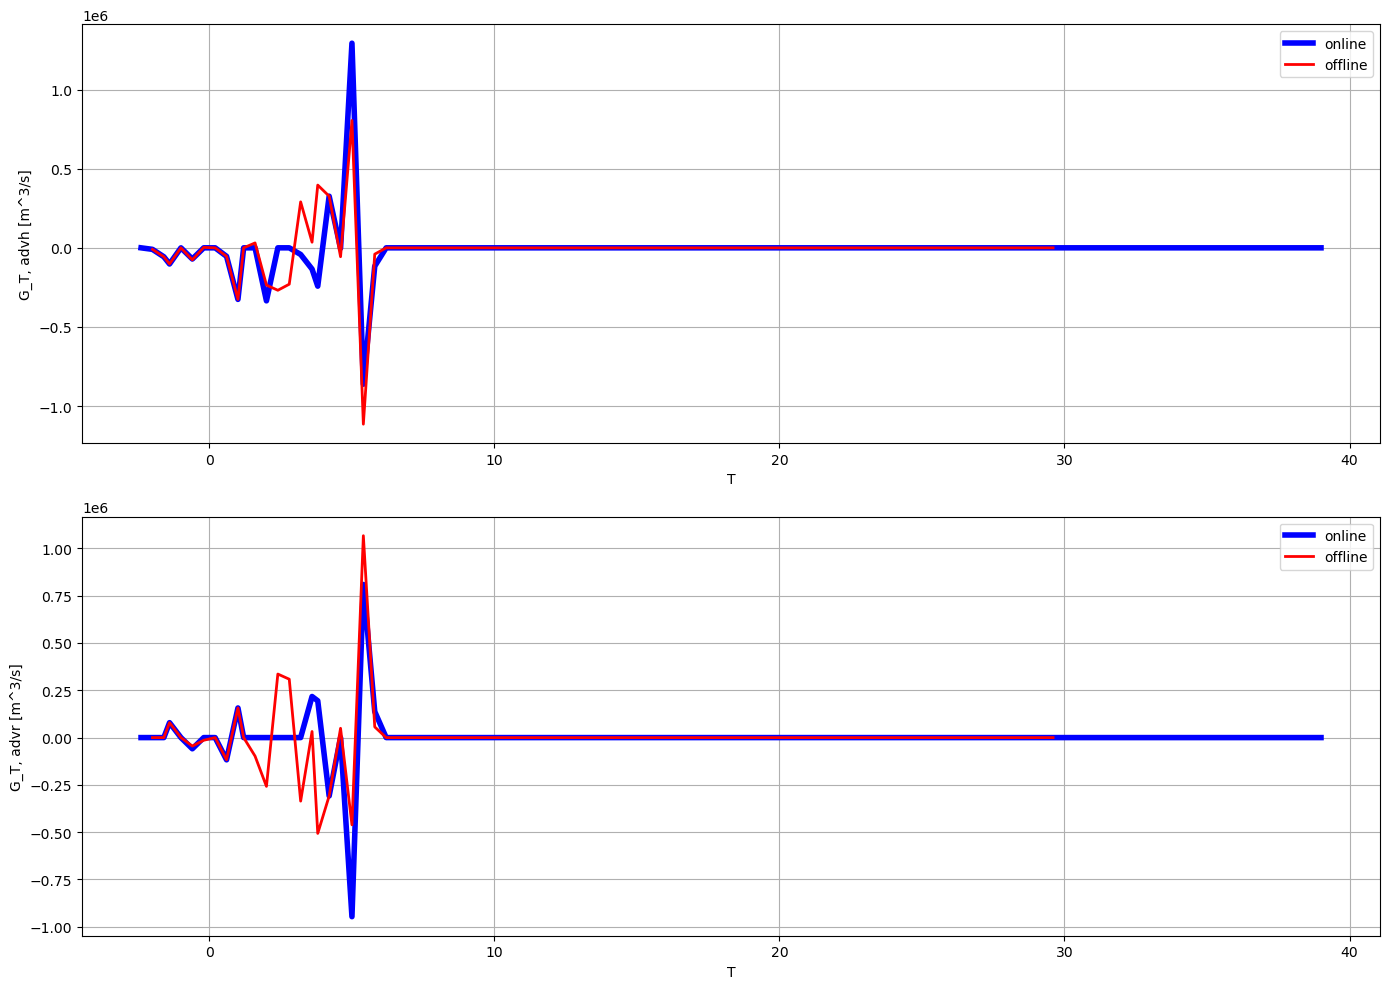

In [41]:
plot_figure4_new(THETA, a, b, boundsT.flatten(), binmidT.flatten(), binwidthT1,
                               GADVh, GADVr, iiT=None)
plt.show()